In [1]:
import pandas as pd
import glob
import json 
import numpy as np
from pandarallel import pandarallel
import requests
# Initialization
pandarallel.initialize(nb_workers=4, use_memory_fs=False)
import matplotlib.pyplot as plt

pd.options.display.width = 150

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
GOOGLE_API= ""
with open("Google_api_key.txt", 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            GOOGLE_API = f.read().strip()

FileNotFoundError: [Errno 2] No such file or directory: 'Google_api_key.txt'

### Concatenante the data 
from the Logic App workflow, we get several json file, hence need to concatenate all together

In [2]:
# concatenate the json files
df = pd.read_json('.\WithCoordinates_Finnyeardata_WholeNorway\WithCoordinates_2021_Finnyeardata_WholeNorway_2021_label_7.json')

In [3]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type
0,"SOFIENBERGGATA 23, Oslo",256360471,https://www.finn.no/realestate/homes/ad.html?f...,1,7,2021,59.92202,NaN,10.76317,0,Eier (Selveier),Garasje/Parkering,10,2021,realestate
1,"Ørstrandveien 62, Svensby",238899888,https://www.finn.no/realestate/homes/ad.html?f...,1,7,2021,69.81904,NaN,19.98484,1,Eier (Selveier),Gårdsbruk/Småbruk,63,2021,realestate


In [4]:
data = []

for f in glob.glob(".\WithCoordinates_Finnyeardata_WholeNorway\*.json"):

    with open(f,) as infile:

        data.extend(json.load(infile))


with open("merged_file.json",'w') as outfile:

    json.dump(data, outfile)



In [5]:
len(data)

6961

### Data Cleaning

In [6]:
df = pd.DataFrame(data)

In [7]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type
0,"Lundadalsvegen 259, Lundamo",260428160,https://www.finn.no/realestate/homes/ad.html?f...,1,6,1850,63.13540,LUNDAMO,10.31820,3,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,128.0,1850,realestate
1,"Norumveien 58, SÃ¸rum",259128262,https://www.finn.no/realestate/homes/ad.html?f...,1,6,1850,60.03278,SÃ¸rum,11.22700,3,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,189.0,1850,realestate
2,"Jahrenveien 79, Fetsund",260954618,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,59.90740,Fetsund,11.16590,1,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,125.0,1850,realestate
3,"Borreveien 136 og 138, Horten",252179712,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,59.38591,None,10.46539,6,Eier (Selveier),Enebolig,343.0,1850,realestate
4,"LÃ¸landsveien 429, Lindesnes",260891785,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,58.20019,None,7.33795,2,Eier (Selveier),Enebolig,84.0,1850,realestate


### keep only the private housing: 

In the current dataset there is 'Leilighet', 'Leilighet', 'Rekkehus', 'Tomannsbolig',
       'Gårdsbruk/Småbruk', 'Bygård/Flermannsbolig', 'Andre',
       'Produksjon/Industri', 'Annet fritid', 'Garasje/Parkering'
       
**We keep only Leilighet, Enebolig, Rekkehus, Tomannsbolig.**

In [8]:
for element in ['Gårdsbruk/Småbruk', 'Bygård/Flermannsbolig', 'Andre', 
       'Produksjon/Industri', 'Annet fritid', 'Garasje/Parkering']:
    df.drop(df[df['property_type_description']==element].index,inplace=True)

In [9]:
df['property_type_description'].value_counts()

Leilighet                 3301
Enebolig                  2711
Tomannsbolig               460
Rekkehus                   385
GÃ¥rdsbruk/SmÃ¥bruk         66
BygÃ¥rd/Flermannsbolig      10
Name: property_type_description, dtype: int64

In [10]:
df['owner_type_description'].value_counts()

Eier (Selveier)    5428
Andel              1445
Aksje                59
Obligasjon            1
Name: owner_type_description, dtype: int64

## energy labels 

dict ={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}

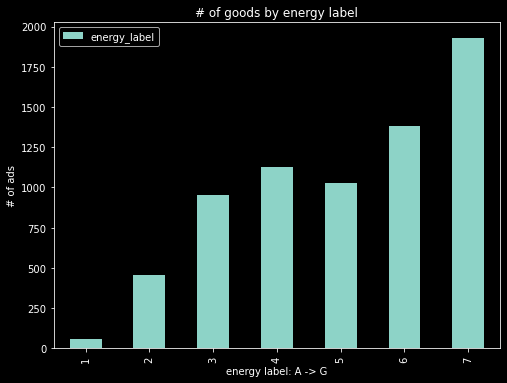

In [12]:
df['energy_label'].value_counts().sort_index().plot.bar(figsize=(8,6))
plt.style.use("dark_background")
plt.title('# of goods by energy label')
plt.xlabel('energy label: A -> G')
plt.ylabel('# of ads')
plt.legend(labelcolor = "white")

plt.savefig('../illustrations/nr_ads_by_energetic_labels.png')

### Categorization of the ads by the year of the building

- The baseline correlation is -0.736159 between the year of the building and the energy label 
- we increase it to 75% if define a cut off on 1901 and categorising by 5 years 
- cut off ≈ 1950 / 1960 => 82% and then need to play with the categorization ( 1 to 10 years ? )

**TEK**
In Norway the laws for the buildings were: TEK69 TEK87, TEK97,TEK07,TEK10, TEK17

In [14]:
def CategoriseBuilding(year):
    if year < 1969:
        byggear_cat = 0
    elif year < 1987:
        byggear_cat = 1
    elif year < 1997:
        byggear_cat = 2
    elif year < 2007:
        byggear_cat = 3
    elif year < 2010:
        byggear_cat = 4
    elif year < 2017:
        byggear_cat = 5
    elif year >= 2017:
        byggear_cat = 6
        
    return byggear_cat


In [15]:
df['byggear_cat'] = df['to_year'].apply(lambda x: CategoriseBuilding(x))

In [17]:
df2= pd.DataFrame(df['byggear_cat'].value_counts())

In [18]:
df2 = df2.sort_index()

In [19]:
df2= df2.rename(index={0:'no TEK',1:'TEK69',2:'TEK87',3:'TEK97',4:'TEK07',5:'TEK10',6:'TEK17'})

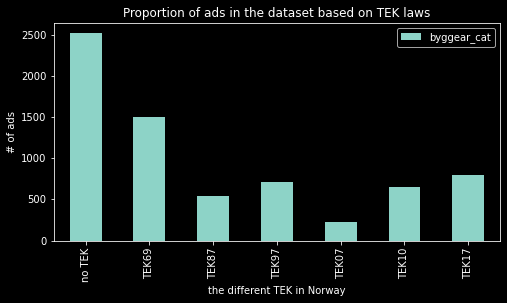

In [20]:
df2.plot.bar(figsize=(8,4))
plt.style.use("dark_background")
plt.title('Proportion of ads in the dataset based on TEK laws')
plt.xlabel('the different TEK in Norway')
plt.ylabel('# of ads')

plt.savefig('../illustrations/nr_ads_by_TEK_cat.png')

###  analysis of the energy label population within the different TEKsubsets

In [21]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type,byggear_cat
0,"Lundadalsvegen 259, Lundamo",260428160,https://www.finn.no/realestate/homes/ad.html?f...,1,6,1850,63.13540,LUNDAMO,10.31820,3,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,128.0,1850,realestate,0
1,"Norumveien 58, SÃ¸rum",259128262,https://www.finn.no/realestate/homes/ad.html?f...,1,6,1850,60.03278,SÃ¸rum,11.22700,3,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,189.0,1850,realestate,0
2,"Jahrenveien 79, Fetsund",260954618,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,59.90740,Fetsund,11.16590,1,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,125.0,1850,realestate,0
3,"Borreveien 136 og 138, Horten",252179712,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,59.38591,None,10.46539,6,Eier (Selveier),Enebolig,343.0,1850,realestate,0
4,"LÃ¸landsveien 429, Lindesnes",260891785,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,58.20019,None,7.33795,2,Eier (Selveier),Enebolig,84.0,1850,realestate,0


In [71]:
df_pivot =df[['byggear_cat','energy_label']].value_counts().sort_index()

In [72]:
df_pivot.head(10)

byggear_cat  energy_label
0            1                  1
             2                 15
             3                 52
             4                 85
             5                147
             6                555
             7               1660
1            1                  1
             2                  9
             3                 12
dtype: int64

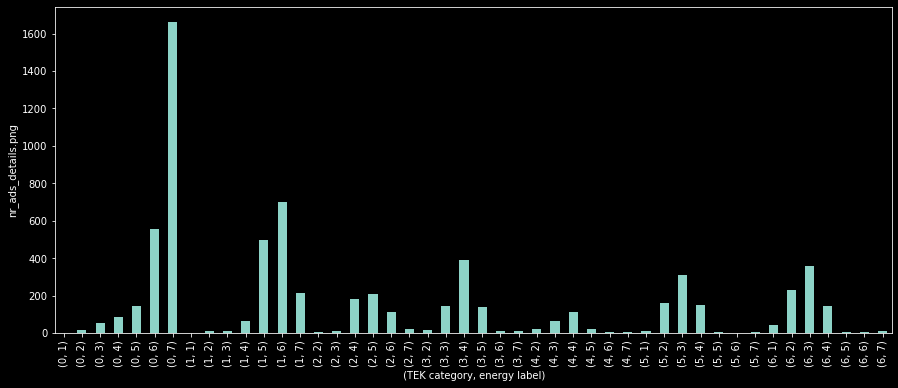

In [73]:
plt.style.use("dark_background")
df_pivot.plot.bar(figsize=(15,6))
plt.savefig('proportion.pdf')

plt.xlabel(' (TEK category, energy label)')
plt.ylabel('nr_ads_details.png')
plt.savefig('../illustrations/nr_ads_by_TEK_and_labels')

#####  anomalies investigation
e.g.
- (0,2): no TEK and energy label B: apartment or houses renovert
- (6,5): TEK17 and label E: poor isolated building
- (6,7): TEk17 and label G: maybe one fully renovert the rest is new buildings 

In [74]:
temp_df = df[df['byggear_cat']==6]

In [75]:
temp_df[temp_df['energy_label']==7].ad_link

6353    https://www.finn.no/realestate/homes/ad.html?f...
6355    https://www.finn.no/realestate/homes/ad.html?f...
6356    https://www.finn.no/realestate/homes/ad.html?f...
6357    https://www.finn.no/realestate/homes/ad.html?f...
6358    https://www.finn.no/realestate/homes/ad.html?f...
6577    https://www.finn.no/realestate/homes/ad.html?f...
6897    https://www.finn.no/realestate/homes/ad.html?f...
6898    https://www.finn.no/realestate/homes/ad.html?f...
6899    https://www.finn.no/realestate/homes/ad.html?f...
6900    https://www.finn.no/realestate/homes/ad.html?f...
6960    https://www.finn.no/realestate/homes/ad.html?f...
Name: ad_link, dtype: object

In [76]:
df.isnull().sum()

Location                        0
ad_id                           0
ad_link                         0
ad_type                         0
energy_label                    0
from_year                       0
lat                             0
local_area_name              2237
lon                             0
number_of_bedrooms              0
owner_type_description          0
property_type_description       0
size_from                       1
to_year                         0
type                            0
byggear_cat                     0
dtype: int64

In [77]:
df = df.drop(['local_area_name'], axis = 1)

In [78]:
df = df.dropna(axis=0)

In [79]:
df.isnull().sum()

Location                     0
ad_id                        0
ad_link                      0
ad_type                      0
energy_label                 0
from_year                    0
lat                          0
lon                          0
number_of_bedrooms           0
owner_type_description       0
property_type_description    0
size_from                    0
to_year                      0
type                         0
byggear_cat                  0
dtype: int64

## Improve the correlation building's year and energy label

In [80]:
corr_global = df.corr()['energy_label']['byggear_cat']
#correlation year building vs energy label in function of the type of buildings

corr_energy_labels_vs_type_ads=[]
for type_ads in df['property_type_description'].unique():
    local_corr = df[df['property_type_description'] == type_ads].corr()['energy_label']['byggear_cat']
    corr_energy_labels_vs_type_ads.append(abs(local_corr))
    
labels = df['property_type_description'].unique()

In [81]:
df_correlation= pd.DataFrame({'Type_Announces':labels,'Correlation':corr_energy_labels_vs_type_ads})

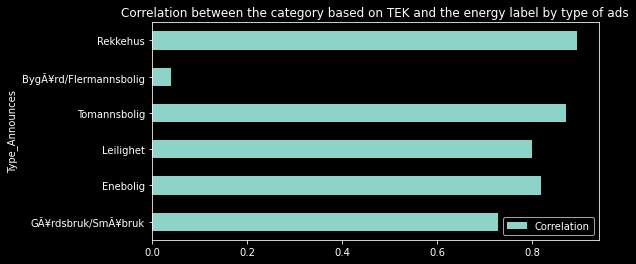

In [83]:
plt.style.use("dark_background")
df_correlation.plot.barh(x='Type_Announces',y='Correlation',figsize=(8,4),title='Correlation between the category based on TEK and the energy label by type of ads')
plt.savefig('../illustrations/correlation_by_type_building.png')

In [84]:
df.corr()

,ad_id,ad_type,energy_label,from_year,lat,lon,number_of_bedrooms,size_from,to_year,byggear_cat
ad_id,1.000000,NaN,0.033151,-0.025054,-0.127556,-0.048102,-0.057314,-0.052989,-0.025054,-0.049964
ad_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_label,0.033151,NaN,1.000000,-0.737008,0.053521,0.064501,0.078362,0.101279,-0.737008,-0.823377
from_year,-0.025054,NaN,-0.737008,1.000000,-0.005816,-0.024953,-0.051942,-0.088264,1.000000,0.837475
lat,-0.127556,NaN,0.053521,-0.005816,1.000000,0.704447,0.057061,0.004965,-0.005816,-0.051568
lon,-0.048102,NaN,0.064501,-0.024953,0.704447,1.000000,0.004700,-0.011311,-0.024953,-0.055228
number_of_bedrooms,-0.057314,NaN,0.078362,-0.051942,0.057061,0.004700,1.000000,0.744723,-0.051942,-0.095981
size_from,-0.052989,NaN,0.101279,-0.088264,0.004965,-0.011311,0.744723,1.000000,-0.088264,-0.155048
to_year,-0.025054,NaN,-0.737008,1.000000,-0.005816,-0.024953,-0.051942,-0.088264,1.000000,0.837475
byggear_cat,-0.049964,NaN,-0.823377,0.837475,-0.051568,-0.055228,-0.095981,-0.155048,0.837475,1.000000


### Categorise of the ownership type

In [85]:
dict_ownership = {'Eier (Selveier)':1,'Andel':2,'Aksje':3,'Obligasjon':4}

In [86]:
df['ownership_cat'] = df['owner_type_description'].map(dict_ownership)

### categorise the property type

In [87]:
dict_property_type_cat = {'Leilighet':1,'Enebolig':2,'Rekkehus':3,'Tomannsbolig':4}
df['property_type_cat']= df['property_type_description'].map(dict_property_type_cat)

## Get Elevation

In [88]:
def GetElevation(coordinates):
    lat, lon = coordinates.split(',')
    url = f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat},{lon}&key={GOOGLE_API}"

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    #print(response.text)
    response=response.json()
    return response['results'][0]['elevation']

df['lat,lon'] = df['lat'].astype(str)+','+ df['lon'].astype(str)

#RUN ONLY if needed, takes 20min ( 8 ads per seconds)
#df['elevation'] = df['lat,lon'].apply(lambda x: GetElevation(x))



## Selecting features



In [89]:
df.columns

Index(['Location', 'ad_id', 'ad_link', 'ad_type', 'energy_label', 'from_year', 'lat', 'lon', 'number_of_bedrooms', 'owner_type_description',
       'property_type_description', 'size_from', 'to_year', 'type', 'byggear_cat', 'ownership_cat', 'property_type_cat', 'lat,lon'],
      dtype='object')

In [90]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type,byggear_cat,ownership_cat,property_type_cat,"lat,lon"
0,"Lundadalsvegen 259, Lundamo",260428160,https://www.finn.no/realestate/homes/ad.html?f...,1,6,1850,63.13540,10.31820,3,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,128.0,1850,realestate,0,1,NaN,"63.1354,10.3182"
1,"Norumveien 58, SÃ¸rum",259128262,https://www.finn.no/realestate/homes/ad.html?f...,1,6,1850,60.03278,11.22700,3,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,189.0,1850,realestate,0,1,NaN,"60.03278,11.227"
2,"Jahrenveien 79, Fetsund",260954618,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,59.90740,11.16590,1,Eier (Selveier),GÃ¥rdsbruk/SmÃ¥bruk,125.0,1850,realestate,0,1,NaN,"59.9074,11.1659"
3,"Borreveien 136 og 138, Horten",252179712,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,59.38591,10.46539,6,Eier (Selveier),Enebolig,343.0,1850,realestate,0,1,2.0,"59.38591,10.46539"
4,"LÃ¸landsveien 429, Lindesnes",260891785,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1850,58.20019,7.33795,2,Eier (Selveier),Enebolig,84.0,1850,realestate,0,1,2.0,"58.20019,7.33795"


In [91]:
output_df=df[['ad_id','lat', 'lon', 'byggear_cat', 'ownership_cat', 'property_type_cat','energy_label']]



## output



In [ ]:
#output_df.to_csv('output_cleaning_step.csv')

In [92]:
df.corr()['energy_label']

ad_id                 0.033151
ad_type                    NaN
energy_label          1.000000
from_year            -0.737008
lat                   0.053521
lon                   0.064501
number_of_bedrooms    0.078362
size_from             0.101279
to_year              -0.737008
byggear_cat          -0.823377
ownership_cat         0.063236
property_type_cat     0.105853
Name: energy_label, dtype: float64

In [93]:
output_df.columns

Index(['ad_id', 'lat', 'lon', 'byggear_cat', 'ownership_cat', 'property_type_cat', 'energy_label'], dtype='object')

In [95]:
output_df[df['size_from'].isnull()]

,ad_id,lat,lon,byggear_cat,ownership_cat,property_type_cat,energy_label


In [96]:
output_df.corr()['energy_label']

ad_id                0.033151
lat                  0.053521
lon                  0.064501
byggear_cat         -0.823377
ownership_cat        0.063236
property_type_cat    0.105853
energy_label         1.000000
Name: energy_label, dtype: float64